In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
pip install git+git://github.com/VIDA-NYU/openclean.git

  Cloning git://github.com/VIDA-NYU/openclean.git to /tmp/pip-req-build-v2uvx7on
  Running command git clone -q git://github.com/VIDA-NYU/openclean.git /tmp/pip-req-build-v2uvx7on
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 266kB 8.4MB/s 
     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 102kB 7.0MB/s 
     |████████████████████████████████| 235kB 16.2MB/s 
     |████████████████████████████████| 532kB 16.9MB/s 
     |████████████████████████████████| 163kB 30.2MB/s 
     |████████████████████████████████| 153kB 39.2MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
  Created wheel for openclean: filename=openclean-0.1.0-cp37-none-any.whl size=4897 sha256=e8bc0acb2acd7abcec2826664d840a85704da2e497ebfc7e5cbc5332b54b8807
  Stored in directory: /tmp/pip-ephem-wheel-cache-vhah7ok5/wheels/5f/de/0d/3f94f0323cd128a09f597f9c646d4d57

## Import data

In [4]:
# Initialize dataframe with MTA data file from 03/20/2021
mta_df = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_210320.txt")

In [5]:
## Read in rest of MTA data, dating back to 01/02/2020 (earliest date in COVID database)

# Earliest date in COVID database
start_date = datetime(2020, 1, 2)
# Up to initial date of mta_df
end_date = datetime(2021, 3, 19)

# Concatenate data files
for i in range(int((end_date - start_date).days)):
  curr_date = end_date - timedelta(i)
  
  try:
    # Read in current data file
    curr_df = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt".format(curr_date.strftime("%y%m%d")))
  except:
    continue
  
  # Concatenate data files
  mta_df = pd.concat([mta_df, curr_df], axis=0)

## Preliminary data profiling & cleaning

In [6]:
# Check rows
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,03:00:00,REGULAR,7543925,2573549
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,07:00:00,REGULAR,7543931,2573559
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,11:00:00,REGULAR,7543970,2573622
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,15:00:00,REGULAR,7544072,2573700
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/13/2021,19:00:00,REGULAR,7544219,2573729


In [7]:
# Check info
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13330595 entries, 0 to 206498
Data columns (total 11 columns):
 #   Column                                                                Dtype 
---  ------                                                                ----- 
 0   C/A                                                                   object
 1   UNIT                                                                  object
 2   SCP                                                                   object
 3   STATION                                                               object
 4   LINENAME                                                              object
 5   DIVISION                                                              object
 6   DATE                                                                  object
 7   TIME                                                                  object
 8   DESC                                                          

In [8]:
# Convert column names to lowercase & strip whitespace
mta_df.rename(columns=lambda x: x.lower().rstrip(), inplace=True)

In [9]:
# Reset index values
mta_df = mta_df.reset_index(drop=True)

In [10]:
# Convert date column to datetime
mta_df['date'] = pd.to_datetime(mta_df['date'], format="%m/%d/%Y")

In [11]:
# Confirm formatting changes
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13330595 entries, 0 to 13330594
Data columns (total 11 columns):
 #   Column    Dtype         
---  ------    -----         
 0   c/a       object        
 1   unit      object        
 2   scp       object        
 3   station   object        
 4   linename  object        
 5   division  object        
 6   date      datetime64[ns]
 7   time      object        
 8   desc      object        
 9   entries   int64         
 10  exits     int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 1.1+ GB


In [12]:
# Extract min date
mta_df['date'].min()

Timestamp('2019-12-28 00:00:00')

In [13]:
# Remove records whose dates go back too far
mta_df = mta_df[mta_df['date'] >= datetime(2020, 1, 2)]

In [14]:
# Confirm acceptable min date
mta_df['date'].min()

Timestamp('2020-01-02 00:00:00')

In [15]:
# Inspect station names
pd.set_option('max_rows', None)
print(mta_df['station'].value_counts())

print("\nThere are {} unique values in this list of NYC subway stations".format(len(mta_df['station'].unique())))

34 ST-PENN STA     266676
FULTON ST          256070
GRD CNTRL-42 ST    214262
23 ST              193872
86 ST              170689
CANAL ST           153816
CHAMBERS ST        145630
34 ST-HERALD SQ    144036
59 ST              136657
42 ST-PORT AUTH    135380
14 ST              135314
ATL AV-BARCLAY     133386
WALL ST            131817
TIMES SQ-42 ST     117402
125 ST             113919
PATH NEW WTC       113640
14 ST-UNION SQ     109069
59 ST COLUMBUS     108924
CORTLANDT ST       103357
28 ST              102942
JAY ST-METROTEC    100603
CHURCH AV           98422
96 ST               98356
161/YANKEE STAD     98240
47-50 STS ROCK      96560
50 ST               95751
METS-WILLETS PT     94401
WTC-CORTLANDT       93011
LEXINGTON AV/53     85150
KINGS HWY           79789
34 ST-HUDSON YD     79121
BOWLING GREEN       77368
72 ST               77103
JAMAICA 179 ST      76736
BOROUGH HALL        72853
FLUSHING-MAIN       69680
8 AV                68695
ST. GEORGE          68332
HARRISON    

In [16]:
# `entries` and `exits` are cumulative counts --> aggregate counts to daily by turnstile
daily_entries_by_turnstile = mta_df.groupby(['c/a', 'unit', 'scp', 'station', 'linename', 'date']).max('entries') - mta_df.groupby(['c/a', 'unit', 'scp', 'station', 'linename', 'date']).min('entries')
daily_exits_by_turnstile = mta_df.groupby(['c/a', 'unit', 'scp', 'station', 'linename', 'date']).max('exits') - mta_df.groupby(['c/a', 'unit', 'scp', 'station', 'linename', 'date']).min('exits')

In [17]:
# Flatten dataframes for merge operation
daily_entries_by_turnstile.reset_index(inplace=True)
daily_exits_by_turnstile.reset_index(inplace=True)

In [18]:
# Check daily_entries_by_turnstile rows
daily_entries_by_turnstile.head()

,c/a,unit,scp,station,linename,date,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,2020-01-02,1355,460
1,A002,R051,02-00-00,59 ST,NQR456W,2020-01-03,1262,459
2,A002,R051,02-00-00,59 ST,NQR456W,2020-01-04,738,317
3,A002,R051,02-00-00,59 ST,NQR456W,2020-01-05,546,214
4,A002,R051,02-00-00,59 ST,NQR456W,2020-01-06,1313,523


In [19]:
# Group by station, linename, date for aggregate daily count by station
daily_traffic_df = pd.merge(daily_entries_by_turnstile, daily_exits_by_turnstile, how='outer').groupby(['station', 'linename', 'date']).sum().reset_index()

In [20]:
# Check daily_traffic_df info
daily_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211680 entries, 0 to 211679
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   station   211680 non-null  object        
 1   linename  211680 non-null  object        
 2   date      211680 non-null  datetime64[ns]
 3   entries   211680 non-null  int64         
 4   exits     211680 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 8.1+ MB


In [21]:
# Analyze unique values of subway station and trainline combos
station_line_values = daily_traffic_df.value_counts(subset=['station', 'linename']).sort_index()

print(station_line_values)
print("\nThere are {} unique values in this list of NYC subway stations and trainlines".format(len(station_line_values)))

station          linename    
1 AV             L               443
103 ST           1               443
                 6               443
                 BC              443
103 ST-CORONA    7               443
104 ST           A               443
                 JZ              443
110 ST           6               443
111 ST           7               443
                 A               443
                 J               443
116 ST           23              443
                 6               443
                 BC              443
116 ST-COLUMBIA  1               441
121 ST           JZ              443
125 ST           1               443
                 23              443
                 456             443
                 ACBD            443
135 ST           23              443
                 BC              443
137 ST CITY COL  1               443
138/GRAND CONC   45              443
14 ST            123FLM          443
                 ACEL            443
        

## Data profiling & cleaning with OpenClean

In [22]:
from openclean.pipeline import stream

# Create openclean data stream
ds = stream(daily_traffic_df)

In [23]:
# Check rows
ds.head()

,station,linename,date,entries,exits
0,1 AV,L,2020-01-02 00:00:00,15135,17646
1,1 AV,L,2020-01-03 00:00:00,15611,18266
2,1 AV,L,2020-01-04 00:00:00,6015,7119
3,1 AV,L,2020-01-05 00:00:00,4724,5530
4,1 AV,L,2020-01-06 00:00:00,16263,18641
5,1 AV,L,2020-01-07 00:00:00,16612,19372
6,1 AV,L,2020-01-08 00:00:00,17206,20275
7,1 AV,L,2020-01-09 00:00:00,17463,20072
8,1 AV,L,2020-01-10 00:00:00,17642,20489
9,1 AV,L,2020-01-11 00:00:00,6971,8220


In [24]:
from openclean.profiling.column import DefaultColumnProfiler

# Profile a sample of 10000 rows from dataset
profile = ds.sample(n=10000, random_state=42).profile(default_profiler=DefaultColumnProfiler)

In [25]:
# Print profiling statistics
profile.stats()

,total,empty,distinct,uniqueness,entropy
station,10000,0,379,0.0379,8.400513
linename,10000,0,114,0.0114,5.734558
date,10000,0,443,0.0443,8.761887
entries,10000,0,5144,0.5144,12.014902
exits,10000,0,4967,0.4967,11.945479


In [26]:
from openclean.profiling.anomalies.sklearn import DBSCANOutliers

# Search for station entries value outliers
DBSCANOutliers(eps=0.02).find(ds.distinct('entries'))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1111,
 10589635,
 13868549,
 419073952,
 11111,
 21409858,
 475740000,
 1666828816,
 1313111,
 1506677570,
 631052148,
 10198672,
 522255]

Some of these values are nonsensically large. Let's see if we can filter out impossible values.

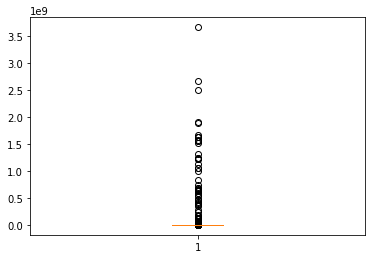

In [27]:
# Visualize entries values
plt.boxplot(daily_traffic_df['entries'])
plt.show()

In [28]:
# 8 million people in NYC -> unlikely all of them pass through a single station on a single day. Set 8M as upper bound
daily_traffic_df = daily_traffic_df[daily_traffic_df['entries'] <= 800000]

# Refresh data stream
ds = stream(daily_traffic_df)

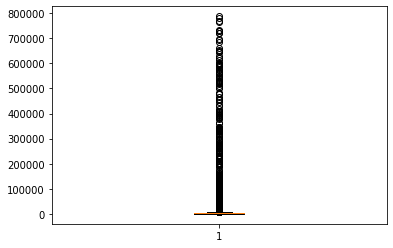

In [29]:
# Re-visualize outliers
plt.boxplot(daily_traffic_df['entries'])
plt.show()

In [30]:
# Search for remaining station entries value outliers
DBSCANOutliers().find(ds.distinct('entries'))

[0]

In [31]:
# Search for station exits value outliers
DBSCANOutliers(eps=0.02).find(ds.distinct('exits'))

[0,
 1,
 2,
 3,
 11,
 1111,
 1222150,
 1070316087,
 6555459,
 1100799,
 3463493,
 1056966762,
 536872013,
 285180608,
 17134387]

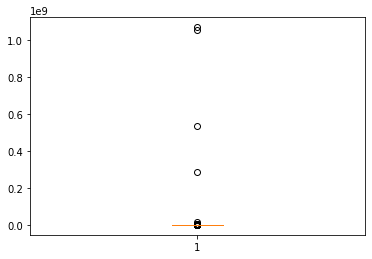

In [32]:
# Visualize exits values
plt.boxplot(daily_traffic_df['exits'])
plt.show()

In [33]:
# Again, set 8M as upper bound
daily_traffic_df = daily_traffic_df[daily_traffic_df['exits'] <= 800000]

# Refresh data stream
ds = stream(daily_traffic_df)

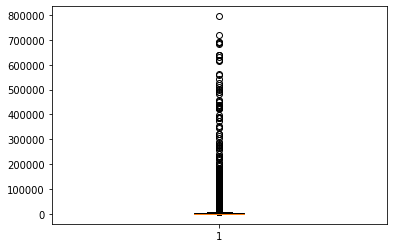

In [34]:
# Re-visualize outliers
plt.boxplot(daily_traffic_df['exits'])
plt.show()

In [35]:
# Search for remaining station exits value outliers
DBSCANOutliers().find(ds.distinct('exits'))

[0]

In [36]:
daily_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211351 entries, 0 to 211679
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   station   211351 non-null  object        
 1   linename  211351 non-null  object        
 2   date      211351 non-null  datetime64[ns]
 3   entries   211351 non-null  int64         
 4   exits     211351 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.7+ MB


In [37]:
# Define function to concatenate stations and linenanmes
def concat_vals(x):
  return "{}".format(x['linename'].strip().replace(" ", ""))

# Concatenate stations and linenames to compute clusters
daily_traffic_df['concat'] = daily_traffic_df.apply(concat_vals, axis=1)

# Refresh data stream
ds = stream(daily_traffic_df)

In [38]:
from openclean.cluster.key import KeyCollision
from openclean.function.value.key.fingerprint import Fingerprint

# Isolate concat column
concats = ds.select('concat')

# Cluster concat column
concat_clusters = concats.cluster(clusterer=KeyCollision(func=Fingerprint(), threads=3))

In [39]:
# Define simple helper method to print the k largest clusters.
def print_k_clusters(clusters, k=10):
    clusters = sorted(clusters, key=lambda x: len(x), reverse=True)
    val_count = sum([len(c) for c in clusters])
    print('Total number of clusters is {} with {} values'.format(len(clusters), val_count))
    for i in range(min(k, len(clusters))):
        print('\nCluster {}'.format(i + 1))
        for key, cnt in clusters[i].items():
            if key == '':
                key = "''"
            print('  {} (x {})'.format(key, cnt))

# Print 10 largest clusters
print_k_clusters(concat_clusters)

Total number of clusters is 0 with 0 values


In [40]:
# Isolate linename column
linenames = ds.select('linename')

# Cluster concat column
line_clusters = linenames.cluster(clusterer=KeyCollision(func=Fingerprint(), threads=3,))

In [41]:
# Print largest clusters
print_k_clusters(line_clusters)

Total number of clusters is 0 with 0 values


In [42]:
## Clustering algorithm failed to identify linename typos -> manually correct errors with lookup table

# Define function to fix linename errors
def fix_linename(x):

  # Define lookup table to fix duplicate values
  duplicate_mapping_dict = {
      '14 ST': {0: 'FLM123', 1: '123FLM'},
      '14 ST-UNION SQ': {0: 'LNQR456W', 1: '456LNQRW'},
      '161/YANKEE STAD': {0: 'BD4', 1: '4BD'},
      '168 ST': {0: 'AC1', 1: '1AC'},
      '42 ST-PORT AUTH': {0: 'ACENGRS1237W', 1: 'ACENQRS1237W'},
      '59 ST COLUMBUS': {0: 'ABCD1', 1: '1ABCD'},
      'ATL AV-BARCLAY': {0: 'BDNQR2345', 1: '2345BDNQR'},
      'BOROUGH HALL': {0: 'R2345', 1: '2345R'},
      'FULTON ST': {0: 'ACJZ2345', 1: '2345ACJZ'}
  }

  # Define lookup table to fix triplicate values
  triplicate_mapping_dict = {
      '34 ST-PENN STA': {0: '123', 1: 'ACE', 2: '123ACE'},
      '59 ST': {0: 'NQR456W', 1: 'NRW', 2: '456NQRW'},
      'TIMES SQ-42 ST': {0: '1237ACENQRS', 1: 'ACENQRS1237W', 2: '1237ACENQRSW'}
  }

  curr_station = x['station']
  curr_line = x['linename']

  # Fix duplicates
  if curr_station in duplicate_mapping_dict:
    if curr_line == duplicate_mapping_dict[curr_station][0]:
      return duplicate_mapping_dict[curr_station][1]
    else:
      return curr_line
  
  # Fix triplicates
  elif curr_station in triplicate_mapping_dict:
    if curr_line == triplicate_mapping_dict[curr_station][0] or curr_line == triplicate_mapping_dict[curr_station][1]:
      return triplicate_mapping_dict[curr_station][2]
    else:
      return curr_line
  
  else:
    return curr_line

In [43]:
# Fix linenames
daily_traffic_df['linename'] = daily_traffic_df.apply(fix_linename, axis=1)

In [44]:
# Analyze corrected subway station and trainline combos
station_line_values = daily_traffic_df.value_counts(subset=['station', 'linename']).sort_index()

print(station_line_values)
print("\nThere are {} unique values in this list of NYC subway stations and trainlines".format(len(station_line_values)))

station          linename    
1 AV             L                443
103 ST           1                442
                 6                443
                 BC               443
103 ST-CORONA    7                443
104 ST           A                443
                 JZ               443
110 ST           6                443
111 ST           7                443
                 A                443
                 J                443
116 ST           23               443
                 6                443
                 BC               442
116 ST-COLUMBIA  1                441
121 ST           JZ               443
125 ST           1                443
                 23               443
                 456              442
                 ACBD             442
135 ST           23               442
                 BC               441
137 ST CITY COL  1                443
138/GRAND CONC   45               443
14 ST            123FLM           885
                 ACE

In [45]:
# Check info
daily_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211351 entries, 0 to 211679
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   station   211351 non-null  object        
 1   linename  211351 non-null  object        
 2   date      211351 non-null  datetime64[ns]
 3   entries   211351 non-null  int64         
 4   exits     211351 non-null  int64         
 5   concat    211351 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.3+ MB


## Basic visulaizations

In [46]:
# Group by date for time-series analysis
total_traffic_df = daily_traffic_df.groupby('date').sum().reset_index()

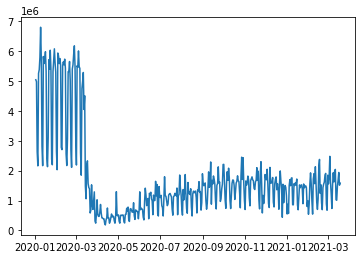

In [47]:
# Plot entries over time
plt.plot('date', 'entries', data=total_traffic_df)

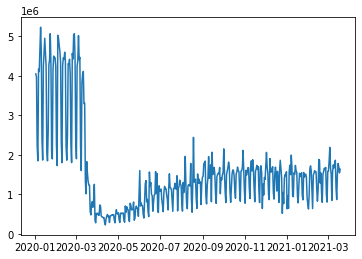

In [48]:
# Plot exits over time
plt.plot('date', 'exits', data=total_traffic_df)